In [13]:
import tensorflow as tf

# model = tf.keras.models.load_model('results/arrhythmia-class-3/model.keras')
import os
import keras

from heartkit.tasks import TaskFactory
from typing import Type, TypeVar
from argdantic import ArgField, ArgParser
from pydantic import BaseModel

from heartkit.defines import (
    HKDemoParams
)

from heartkit.tasks.AFIB_Ident.utils import (
    create_model
)

from heartkit.tasks.AFIB_Ident.defines import (
    get_class_mapping,
    get_class_names,
    get_class_shape,
    get_classes,
    get_feat_shape,
)



cli = ArgParser()
B = TypeVar("B", bound=BaseModel)


def parse_content(cls: Type[B], content: str) -> B:
    """Parse file or raw content into Pydantic model.

    Args:
        cls (B): Pydantic model subclasss
        content (str): File path or raw content

    Returns:
        B: Pydantic model subclass instance
    """
    if os.path.isfile(content):
        with open(content, "r", encoding="utf-8") as f:
            content = f.read()

    return cls.model_validate_json(json_data=content)

task="AFIB_Ident"
task_handler = TaskFactory.get(task)
print(task_handler)

config = 'configs/arrhythmia-100class-2.json'
params = parse_content(HKDemoParams, config)
# task_handler.demo()
input_spec = (
    tf.TensorSpec(shape=get_feat_shape(params.frame_size), dtype=tf.float32),
    tf.TensorSpec(shape=get_class_shape(params.frame_size, params.num_classes), dtype=tf.int32),
)

inputs = keras.Input(shape=input_spec[0].shape, batch_size=None, name="input", dtype=input_spec[0].dtype)

model = create_model(
    inputs,
    num_classes=params.num_classes,
    architecture=None,
)

# Instantiate the model
# model = EfficientNetV2(tf.keras.Input(shape=(224, 224, 3)), params, num_classes=1000)

# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

model.summary()

<class 'heartkit.tasks.AFIB_Ident.AFIB_Ident.AFIB_Ident'>
Model: "EfficientNetV2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 400, 1)]             0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 400, 1)            0         ['input[0][0]']               
                                                                                                  
 stem.conv (Conv2D)          (None, 1, 200, 24)           72        ['reshape_1[0][0]']           
                                                                                                  
 stem.bn (BatchNormalizatio  (None, 1, 200, 24)           96        ['stem.conv[0][0]']           
 n)                        

The model architecture you've shared appears to be a variant of the EfficientNet architecture, which uses MBConv blocks. Here's a breakdown of the layers and their parameters:

1. **Reshape Layer (`reshape_1`)**: This layer reshapes the input tensor to have a shape of `(1, 400, 1)`. 

2. **Convolutional Layer (`stem.conv`)**: This is the first convolutional layer of the model. It has 24 filters and a kernel size of `(1, 2)`, which is applied to the reshaped input.

3. **Batch Normalization Layer (`stem.bn`)**: This layer normalizes the activations of the previous layer.

4. **Activation Layer (`stem.act`)**: This layer applies the ReLU activation function to the normalized activations.

5. **Depthwise Convolutional Layer (`stage1.mbconv1.dp`)**: This layer applies a depthwise convolution to the activations, which means a single filter is applied to each input channel. The layer has 24 filters and a kernel size of `(1, 2)`.

6. **Batch Normalization Layer (`stage1.mbconv1.dp.bn`)**: This layer normalizes the activations of the depthwise convolution.

7. **Activation Layer (`stage1.mbconv1.dp.act`)**: This layer applies the ReLU activation function to the normalized activations.

8. **Max Pooling Layer (`max_pooling2d_4`)**: This layer applies max pooling to the activations, which reduces their spatial dimensions.

9. **Global Average Pooling Layer (`stage1.mbconv1.se.pool`)**: This layer applies global average pooling to the pooled activations, which reduces their spatial dimensions to 1x1.

10. **Convolutional Layer (`stage1.mbconv1.se.sq.conv`)**: This layer applies a 1x1 convolution to the pooled activations, reducing the number of channels to 12.

11. **Activation Layer (`stage1.mbconv1.se.sq.act`)**: This layer applies the ReLU activation function to the convolved activations.

12. **Convolutional Layer (`stage1.mbconv1.se.ex.conv`)**: This layer applies another 1x1 convolution to the activations, expanding the number of channels back to 24.

13. **Activation Layer (`stage1.mbconv1.se.ex.act`)**: This layer applies the ReLU activation function to the convolved activations.

14. **Multiply Layer (`multiply_6`)**: This layer multiplies the activations of the `max_pooling2d_4` layer and the `stage1.mbconv1.se.ex.act` layer, which is a form of feature recalibration often seen in squeeze-and-excitation blocks.

This architecture includes several key components of EfficientNet and MobileNet models, such as depthwise convolutions, squeeze-and-excitation blocks, and expansion and reduction phases. The specific parameters for each layer would be defined in the `MBConvParams` class instance used to create the `MBConvBlock`. I hope this helps! If you have any more questions, feel free to ask. 😊

- MBConvBlock: https://towardsdatascience.com/residual-bottleneck-inverted-residual-linear-bottleneck-mbconv-explained-89d7b7e7c6bc
- referece: https://stats.stackexchange.com/questions/518240/what-is-mbconv-that-efficientnetv2-is-using

The `mbconv1` and `mbconv2` you see in the layer names represent two different MBConv blocks within the same stage (`stage1`) of the model. 

An MBConv block is a type of convolutional block used in EfficientNet models. It consists of an expansion phase, a depthwise convolution phase, a squeeze-and-excitation phase, and a reduction phase.

The `mbconv1` block starts with a depthwise convolution (`stage1.mbconv1.dp`), followed by batch normalization and ReLU activation. Then, it applies max pooling to reduce the spatial dimensions. After that, it goes through a squeeze-and-excitation operation (`stage1.mbconv1.se.pool`, `stage1.mbconv1.se.sq.conv`, `stage1.mbconv1.se.ex.conv`), which adaptively recalibrates the channel-wise feature responses. Finally, it reduces the number of channels to the desired amount (`stage1.mbconv1.red.conv`) and applies batch normalization.

The `mbconv2` block starts after the `mbconv1` block and applies another depthwise convolution (`stage1.mbconv2.dp`). The rest of the `mbconv2` block is not shown in the provided model summary, but it would typically follow the same pattern of operations as the `mbconv1` block.

The main difference between `mbconv1` and `mbconv2` in this context is that they are different blocks within the same stage of the model, each applying a set of operations to their input tensors. The specific parameters for each block (like the number of filters, the kernel size, the stride size, etc.) would be defined in the `MBConvParams` class instances used to create the blocks. I hope this helps! If you have any more questions, feel free to ask. 😊

In the context of a convolutional neural network block, the combination of a depthwise convolution (`DepthwiseConv2D`) followed by batch normalization (`BatchNormalization`) works as follows:

1. **Depthwise Convolution (`DepthwiseConv2D`)**: This is a variant of the standard convolution operation. In a standard convolution, each filter is applied across all channels of the input. In contrast, in a depthwise convolution, each filter is applied to a single input channel. This can significantly reduce the computational cost of the convolution operation, especially when the number of input channels is large. The output of this operation is a set of feature maps, one for each input channel.

2. **Batch Normalization (`BatchNormalization`)**: This operation normalizes the output of the depthwise convolution. It reduces the internal covariate shift by normalizing the activations of each feature map to have zero mean and unit variance. This can make the network more stable and easier to train. It also acts as a form of regularization, reducing the risk of overfitting.

The combination of depthwise convolution and batch normalization is a common pattern in modern convolutional neural networks. It allows the network to learn complex patterns from the input data in a computationally efficient manner, while also improving the stability of the training process. I hope this helps! If you have any more questions, feel free to ask. 😊

In [8]:
task_handler

heartkit.tasks.AFIB_Ident.AFIB_Ident.AFIB_Ident

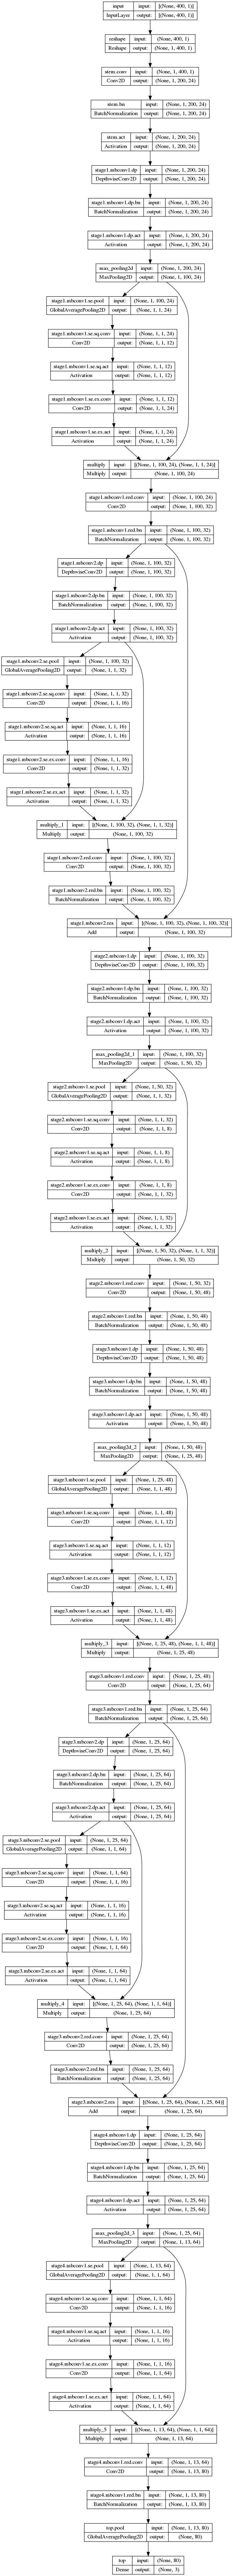

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [3]:
model.summary()

Model: "EfficientNetV2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 400, 1)]             0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 400, 1)            0         ['input[0][0]']               
                                                                                                  
 stem.conv (Conv2D)          (None, 1, 200, 24)           72        ['reshape[0][0]']             
                                                                                                  
 stem.bn (BatchNormalizatio  (None, 1, 200, 24)           96        ['stem.conv[0][0]']           
 n)                                                                                  